# Import Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

pd.set_option("display.precision", 3)

In [2]:
orders_path = 'quality_data/orders_qu.csv'
orderlines_path = 'quality_data/orderlines_qu.csv'
products_path = 'quality_data/products_qu.csv'
brands_path = 'clean_data/brands.csv'

# convert to dataframe

orders_qu = pd.read_csv(orders_path)
orderlines_qu = pd.read_csv(orderlines_path)
products_qu = pd.read_csv(products_path)
brands_qu = pd.read_csv(brands_path)

# Data type Correction

In [3]:
orders_qu = orders_qu.astype({"order_id":"str",
                        "created_date":"datetime64[ns]"
                       })

orderlines_qu = orderlines_qu.astype({"id":"str",
                                "order_id":"str",
                                "date":"datetime64[ns]"
                               })

In [4]:
orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163750 entries, 0 to 163749
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      163750 non-null  object        
 1   created_date  163750 non-null  datetime64[ns]
 2   total_paid    163750 non-null  float64       
 3   status        163750 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.0+ MB


In [5]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205403 entries, 0 to 205402
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                205403 non-null  object        
 1   order_id          205403 non-null  object        
 2   product_quantity  205403 non-null  int64         
 3   sku               205403 non-null  object        
 4   unit_price        205403 non-null  float64       
 5   date              205403 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 9.4+ MB


In [6]:
products_qu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6411 entries, 0 to 6410
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sku       6411 non-null   object 
 1   name      6411 non-null   object 
 2   desc      6411 non-null   object 
 3   price     6411 non-null   float64
 4   in_stock  6411 non-null   bool   
 5   p_type    6411 non-null   object 
dtypes: bool(1), float64(1), object(4)
memory usage: 256.8+ KB


In [7]:
brands_qu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   short   187 non-null    object
 1   long    187 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


# Data Preparation for Analysis

## 1. Products_qu table prep

#### categorization 1 : price_range

In [8]:
# create price_range column showing cheap or costly products

products_c = products_qu.copy()

products_c['price_range'] = np.where(products_c.price <= 500, 'cheap', 'expensive')

#### categorization 2 : category - product type

In [9]:
# product category creation

products_c['category'] = 'Miscellaneous'


# cat1 Desktop
products_c.loc[products_c['name'].str.contains('iMac|TB|Monitor|TV|Display|Server|Network|Game|Stream|Gaming',
                                           na=False, case=False), 'category'] = 'Desktop'

# cat2 Laptop
products_c.loc[products_c['name'].str.contains('MacBook|Laptop|Portable|Bluetooth',
                                           na=False, case=False), 'category'] = 'Laptop'

# cat3 Tablet
products_c.loc[products_c['name'].str.contains('iPad|Tablet|Wacom',
                                           na=False, case=False), 'category'] = 'Tablet'

# cat4 phone
products_c.loc[products_c['name'].str.contains('Phone',
                                           na=False, case=False), 'category'] = 'Phone'

# cat5 music
products_c.loc[products_c['name'].str.contains('Woofer|Headphone|Sound|Speaker|Airpod|Headset|iPod|Music|Audio|Multimedia|MIDI',
                                           na=False, case=False), 'category'] = 'Music Devices'

# cat6 storage
products_c.loc[products_c['name'].str.contains('SSD|Disk|HDD|SCSI|DIMM|RAM|RAID|Memory|NAS|Rack|Drive|Battery',
                                           na=False, case=False), 'category'] = 'Storage Systems'

# cat7 watch
products_c.loc[products_c['name'].str.contains('watch',
                                           na=False, case=False), 'category'] = 'Watch'

# cat8 accessories 
products_c.loc[products_c['name'].str.contains('Charger|cable|Keyboard|USB|Mouse|screen|holder|Adapter',
                                           na=False, case=False), 'category'] = 'Accessories'

# cat9 case|covers
products_c.loc[products_c['name'].str.contains('case|cover',
                                           na=False, case=False), 'category'] = 'Case'

# cat10 security products
#products_c.loc[products_c['name'].str.contains('license',
#                                           na=False, case=False), 'category'] = 'Security Products'

In [10]:
products_qu = products_c.copy()
products_qu.category.value_counts()

Case               1462
Storage Systems    1327
Accessories        1258
Miscellaneous       578
Phone               470
Music Devices       392
Tablet              334
Desktop             315
Laptop              164
Watch               111
Name: category, dtype: int64

## 2. Outliers removal

### 2.1 Difference : toal_paid, total_unit_price (order_value)

In [11]:
orders_qu.total_paid.count()

163750

In [12]:
orders_qu.status.value_counts()

Shopping Basket    81292
Completed          41701
Place Order        22786
Pending            12708
Cancelled           5263
Name: status, dtype: int64

#### 3.1.1 create order_value

In [13]:
ol_q = orderlines_qu.copy()
o_q = orders_qu.copy()

# product of qty and unit_price
ol_q["unit_price_total"] = ol_q["product_quantity"] * ol_q["unit_price"]

# new df--> group by order_id take sum of unit_price
ol_q_group_order_df = ol_q.groupby("order_id", as_index=False)["unit_price_total"].sum()

diff_df = o_q.merge(ol_q_group_order_df,
                               how = 'inner',
                               on="order_id"
                               )
diff_df

,order_id,created_date,total_paid,status,unit_price_total
0,241319,2017-01-02 13:35:40,44.99,Cancelled,44.99
1,241423,2017-11-06 13:10:02,136.15,Completed,129.16
2,242832,2017-12-31 17:40:03,15.76,Completed,10.77
3,243330,2017-02-16 10:59:38,84.98,Completed,77.99
4,243784,2017-11-24 13:35:19,157.86,Cancelled,153.87
...,...,...,...,...,...
163745,527397,2018-03-14 13:56:38,42.99,Place Order,42.99
163746,527398,2018-03-14 13:57:25,42.99,Shopping Basket,42.99
163747,527399,2018-03-14 13:57:34,141.58,Shopping Basket,141.58
163748,527400,2018-03-14 13:57:41,19.98,Shopping Basket,19.98


In [14]:
diff_df["difference"] = np.where(diff_df.status=='Completed',
                                 diff_df["total_paid"] - diff_df["unit_price_total"],
                                 np.nan)
diff_df.head()

,order_id,created_date,total_paid,status,unit_price_total,difference
0,241319,2017-01-02 13:35:40,44.99,Cancelled,44.99,NaN
1,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
2,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
3,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
4,243784,2017-11-24 13:35:19,157.86,Cancelled,153.87,NaN


In [15]:
diff_df.difference.describe()

count    41701.000
mean         4.475
std         26.046
min       -165.000
25%          0.000
50%          4.990
75%          6.990
max       3984.990
Name: difference, dtype: float64

<Axes: xlabel='difference'>

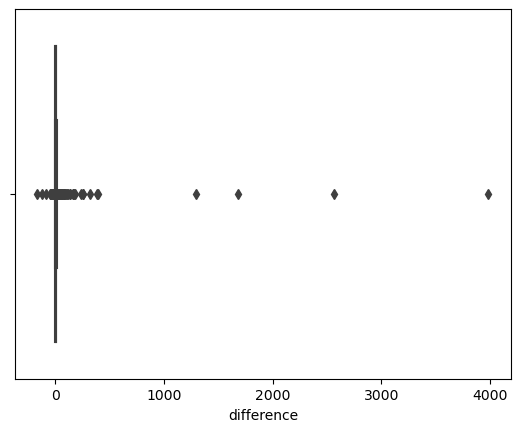

In [16]:
sns.boxplot(x=diff_df.difference)

In [17]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[((diff_df["difference"] >= (Q1 - 1.5*IQR)) &
                                  (diff_df["difference"] <= (Q3 + 1.5*IQR)))|
                                  (diff_df['difference'].isna())]
diff_no_outliers_df

,order_id,created_date,total_paid,status,unit_price_total,difference
0,241319,2017-01-02 13:35:40,44.99,Cancelled,44.99,NaN
1,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
2,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
3,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
4,243784,2017-11-24 13:35:19,157.86,Cancelled,153.87,NaN
...,...,...,...,...,...,...
163745,527397,2018-03-14 13:56:38,42.99,Place Order,42.99,NaN
163746,527398,2018-03-14 13:57:25,42.99,Shopping Basket,42.99,NaN
163747,527399,2018-03-14 13:57:34,141.58,Shopping Basket,141.58,NaN
163748,527400,2018-03-14 13:57:41,19.98,Shopping Basket,19.98,NaN


#### 3.1.2 Outlier remove : Orders_qu Orderlines_qu

In [18]:
normal_diff_list = list(diff_no_outliers_df["order_id"])

orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["order_id"].isin(normal_diff_list), :]

len(orders_qu["order_id"].unique()), len(orderlines_qu["order_id"].unique())

(163034, 163034)

### 2.2 Discount : unit_price, price

In [19]:
orders_d = orders_qu.copy()
orderlines_d = orderlines_qu.copy()
products_d = products_qu.copy()

In [20]:
products_d.price.describe()

count    6411.000
mean      230.591
std       372.998
min         2.990
25%        36.990
50%        79.900
75%       259.000
max      7179.000
Name: price, dtype: float64

In [21]:
products_d[products_d.price>5000]['sku'].count()

1

In [22]:
cost_sku = list(products_d[products_d.price>5000]['sku'])
orderlines_qu.loc[orderlines_qu.sku.isin(cost_sku)]

,id,order_id,product_quantity,sku,unit_price,date
178803,1574478,496269,1,APP2674,6.59,2018-01-22 18:07:59


only one order is there for price > 5000, and interestingly it is sold for 6.59.

In [23]:
# merge
ol_p = orderlines_d.merge(products_d, on='sku', how='left')
ol_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204310 entries, 0 to 204309
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                204310 non-null  object        
 1   order_id          204310 non-null  object        
 2   product_quantity  204310 non-null  int64         
 3   sku               204310 non-null  object        
 4   unit_price        204310 non-null  float64       
 5   date              204310 non-null  datetime64[ns]
 6   name              204310 non-null  object        
 7   desc              204310 non-null  object        
 8   price             204310 non-null  float64       
 9   in_stock          204310 non-null  bool          
 10  p_type            204310 non-null  object        
 11  price_range       204310 non-null  object        
 12  category          204310 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object

#### 3.2.1 discount & discount_perc

In [24]:
ol_p['promotion'] = ol_p['unit_price'] < ol_p['price']

In [25]:
# no of promotioned orderlines
ol_p['promotion'].value_counts()

True     184317
False     19993
Name: promotion, dtype: int64

In [26]:
ol_p['discount'] = np.where(ol_p['promotion'],ol_p['price']-ol_p['unit_price'],np.nan)

ol_p = (
    ol_p.
    assign(discount_perc = ol_p.discount *100.0 / ol_p.price))

ol_p.info()
ol_p.order_id.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204310 entries, 0 to 204309
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                204310 non-null  object        
 1   order_id          204310 non-null  object        
 2   product_quantity  204310 non-null  int64         
 3   sku               204310 non-null  object        
 4   unit_price        204310 non-null  float64       
 5   date              204310 non-null  datetime64[ns]
 6   name              204310 non-null  object        
 7   desc              204310 non-null  object        
 8   price             204310 non-null  float64       
 9   in_stock          204310 non-null  bool          
 10  p_type            204310 non-null  object        
 11  price_range       204310 non-null  object        
 12  category          204310 non-null  object        
 13  promotion         204310 non-null  bool          
 14  disc

163034

old :
count    205403.000
mean         19.126
std          23.910
min       -4905.005
25%           6.671
50%          15.910
75%          26.081
max         200.000
Name: discount_perc, dtype: float64

In [27]:
ol_p.discount_perc.describe()

count    184317.000
mean         21.591
std          17.373
min           0.001
25%           9.846
50%          17.408
75%          27.781
max         200.000
Name: discount_perc, dtype: float64

<Axes: xlabel='discount_perc'>

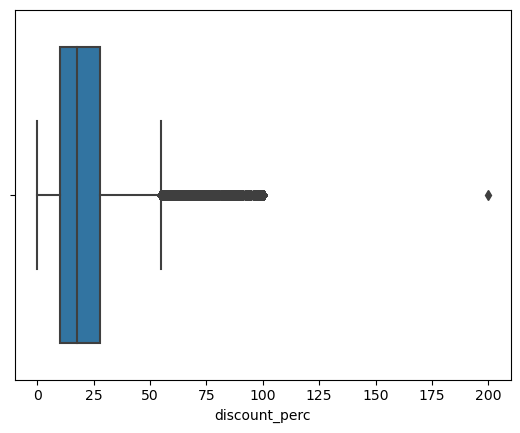

In [28]:
sns.boxplot(x=ol_p.discount_perc)

In [29]:
ol_p[(ol_p.discount_perc<100)|(ol_p.discount_perc.isna())].count()

id                  203813
order_id            203813
product_quantity    203813
sku                 203813
unit_price          203813
date                203813
name                203813
desc                203813
price               203813
in_stock            203813
p_type              203813
price_range         203813
category            203813
promotion           203813
discount            183820
discount_perc       183820
dtype: int64

In [30]:
ol_p[(ol_p.discount_perc>=100)].count()

id                  497
order_id            497
product_quantity    497
sku                 497
unit_price          497
date                497
name                497
desc                497
price               497
in_stock            497
p_type              497
price_range         497
category            497
promotion           497
discount            497
discount_perc       497
dtype: int64

#### 3.2.2 Outlier removal --> orderlines_qu, orders_qu,products_qu

In [31]:
# outliers : korderlines with discount_perc >= 100

outliers_d = ol_p.loc[ol_p.discount_perc>=100]
print(outliers_d.shape)
print(outliers_d.order_id.nunique())

(497, 16)
192


In [32]:
# remove outliers ol_p

ol_p = ol_p.loc[~(ol_p.order_id.isin(outliers_d.order_id))]
print(ol_p.shape)
print(ol_p.order_id.nunique())

(203617, 16)
162842


In [33]:
# orderlines_qu

orderlines_qu = orderlines_qu.loc[orderlines_qu.order_id.isin(ol_p.order_id)]
orderlines_qu.info()
display(orderlines_qu.order_id.nunique())

orders_qu = orders_qu.loc[orders_qu.order_id.isin(ol_p.order_id)]
orders_qu.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203617 entries, 0 to 205402
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                203617 non-null  object        
 1   order_id          203617 non-null  object        
 2   product_quantity  203617 non-null  int64         
 3   sku               203617 non-null  object        
 4   unit_price        203617 non-null  float64       
 5   date              203617 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.9+ MB


162842

(162842, 4)

In [34]:
# prodcuts_qu

products_qu = products_qu.loc[products_qu.sku.isin(orderlines_qu.sku)]
products_qu.info()
orderlines_qu.sku.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6375 entries, 0 to 6410
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sku          6375 non-null   object 
 1   name         6375 non-null   object 
 2   desc         6375 non-null   object 
 3   price        6375 non-null   float64
 4   in_stock     6375 non-null   bool   
 5   p_type       6375 non-null   object 
 6   price_range  6375 non-null   object 
 7   category     6375 non-null   object 
dtypes: bool(1), float64(1), object(6)
memory usage: 404.7+ KB


6375

### 2.3 Dataframe prep

In [35]:
ol_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203617 entries, 0 to 204309
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                203617 non-null  object        
 1   order_id          203617 non-null  object        
 2   product_quantity  203617 non-null  int64         
 3   sku               203617 non-null  object        
 4   unit_price        203617 non-null  float64       
 5   date              203617 non-null  datetime64[ns]
 6   name              203617 non-null  object        
 7   desc              203617 non-null  object        
 8   price             203617 non-null  float64       
 9   in_stock          203617 non-null  bool          
 10  p_type            203617 non-null  object        
 11  price_range       203617 non-null  object        
 12  category          203617 non-null  object        
 13  promotion         203617 non-null  bool          
 14  disc

#### Final data

In [36]:
# final data prep

ol_p = (
    ol_p
    .rename(columns={'product_quantity':'qty','unit_price':'sell_price','p_type':'product_type','date':'date'})
    .loc[:,['order_id','sku','name','price','sell_price','qty','price_range','category','date','promotion','discount','discount_perc','in_stock']]
    .assign(
        year = ol_p['date'].dt.strftime('%Y'), 
        month = ol_p['date'].dt.strftime('%m'),
        year_month = ol_p['date'].dt.strftime('%Y''-''%m')))

ol_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203617 entries, 0 to 204309
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_id       203617 non-null  object        
 1   sku            203617 non-null  object        
 2   name           203617 non-null  object        
 3   price          203617 non-null  float64       
 4   sell_price     203617 non-null  float64       
 5   qty            203617 non-null  int64         
 6   price_range    203617 non-null  object        
 7   category       203617 non-null  object        
 8   date           203617 non-null  datetime64[ns]
 9   promotion      203617 non-null  bool          
 10  discount       183625 non-null  float64       
 11  discount_perc  183625 non-null  float64       
 12  in_stock       203617 non-null  bool          
 13  year           203617 non-null  object        
 14  month          203617 non-null  object        
 15  

In [37]:
# ol_p merge with orders_d and diff_no_outliers_df for 'unit_price_total' column

oop = (
    orders_qu
    .merge(ol_p, on='order_id')
    .merge(diff_no_outliers_df[['unit_price_total','order_id']],on='order_id',how='inner'))

oop = oop.rename(columns={'unit_price_total':'order_value'})
oop.info()
oop.order_id.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203617 entries, 0 to 203616
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_id       203617 non-null  object        
 1   created_date   203617 non-null  datetime64[ns]
 2   total_paid     203617 non-null  float64       
 3   status         203617 non-null  object        
 4   sku            203617 non-null  object        
 5   name           203617 non-null  object        
 6   price          203617 non-null  float64       
 7   sell_price     203617 non-null  float64       
 8   qty            203617 non-null  int64         
 9   price_range    203617 non-null  object        
 10  category       203617 non-null  object        
 11  date           203617 non-null  datetime64[ns]
 12  promotion      203617 non-null  bool          
 13  discount       183625 non-null  float64       
 14  discount_perc  183625 non-null  float64       
 15  

162842

In [38]:
# check for price and discount_perc
# oop.loc[(oop.discount_perc>95)].sort_values('price',ascending=False)

# oop[(oop.discount_perc<95) & (oop.discount_perc>90) & (oop.status=='Completed')].sort_values('price',ascending=False)

# name price product 95% Mophie Powerstation 6000mAh battery Universal ...	89.95 date 2018-02-16 

## 3. Negative Value Check

In [39]:
#. check for negative value
# .lt() : method stands for "less than" and checks element-wise if each value
#    in the selected columns is less than 0 and then returns a DF of boolean values
#    True = (value is less than 0)
# axis=1 is for rows of dataframe
# any() with axis=1 is to check any value in rows

numeric_cols = ['price','sell_price','qty','discount','discount_perc','total_paid','order_value']
neg_value_df = oop[numeric_cols].lt(0).any(axis=1)
neg_value_df.sum()

0

## 4. total_paid value consistency withing order

In [40]:
total_paid_nunique = oop.groupby('order_id')['total_paid'].nunique()
inconsistent_orders = total_paid_nunique[total_paid_nunique > 1]

if inconsistent_orders.any():
    print("There are orders with inconsistent 'total_paid' values:")
    print(oop_cmp[oop_cmp['order_id'].isin(inconsistent_orders.index)])
else:
    print("All orders have consistent 'total_paid' values within order.")

All orders have consistent 'total_paid' values within order.


### oop copy with reset index

In [41]:
df = oop.reset_index(drop=True).copy()

In [42]:
df.columns

Index(['order_id', 'created_date', 'total_paid', 'status', 'sku', 'name',
       'price', 'sell_price', 'qty', 'price_range', 'category', 'date',
       'promotion', 'discount', 'discount_perc', 'in_stock', 'year', 'month',
       'year_month', 'order_value'],
      dtype='object')

## Only Completed Orders

In [43]:
# Only completed orders
oop_cmp = oop[oop.status=='Completed'].copy()
oop_cmp.info()
f'Number of Completed Orders : {oop_cmp.order_id.nunique()}'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53231 entries, 1 to 203340
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       53231 non-null  object        
 1   created_date   53231 non-null  datetime64[ns]
 2   total_paid     53231 non-null  float64       
 3   status         53231 non-null  object        
 4   sku            53231 non-null  object        
 5   name           53231 non-null  object        
 6   price          53231 non-null  float64       
 7   sell_price     53231 non-null  float64       
 8   qty            53231 non-null  int64         
 9   price_range    53231 non-null  object        
 10  category       53231 non-null  object        
 11  date           53231 non-null  datetime64[ns]
 12  promotion      53231 non-null  bool          
 13  discount       49404 non-null  float64       
 14  discount_perc  49404 non-null  float64       
 15  in_stock       532

'Number of Completed Orders : 40985'

In [44]:
# make final df with new index excluding old indexing

df_cmp = oop_cmp.reset_index(drop=True).copy()
df_cmp.columns

Index(['order_id', 'created_date', 'total_paid', 'status', 'sku', 'name',
       'price', 'sell_price', 'qty', 'price_range', 'category', 'date',
       'promotion', 'discount', 'discount_perc', 'in_stock', 'year', 'month',
       'year_month', 'order_value'],
      dtype='object')

In [45]:
df_cmp.year.unique()

array(['2017', '2018'], dtype=object)

# Data Anaylsis

### 1. Average daily order_value & Average order size

In [46]:
# average order value
avg_order_value = df_cmp.groupby('order_id')['total_paid'].first().mean()
avg_order_value

194.67306575576427

In [47]:
# average order size
avg_order_size = df_cmp.groupby('order_id').size().mean()
avg_order_size

1.2987922410638038

In [48]:
df_cmp.groupby('order_id')['total_paid'].first().describe()

count    40985.000
mean       194.673
std        250.508
min          2.820
25%         46.980
50%         98.040
75%        244.990
max       6876.940
Name: total_paid, dtype: float64

194.67306575576427

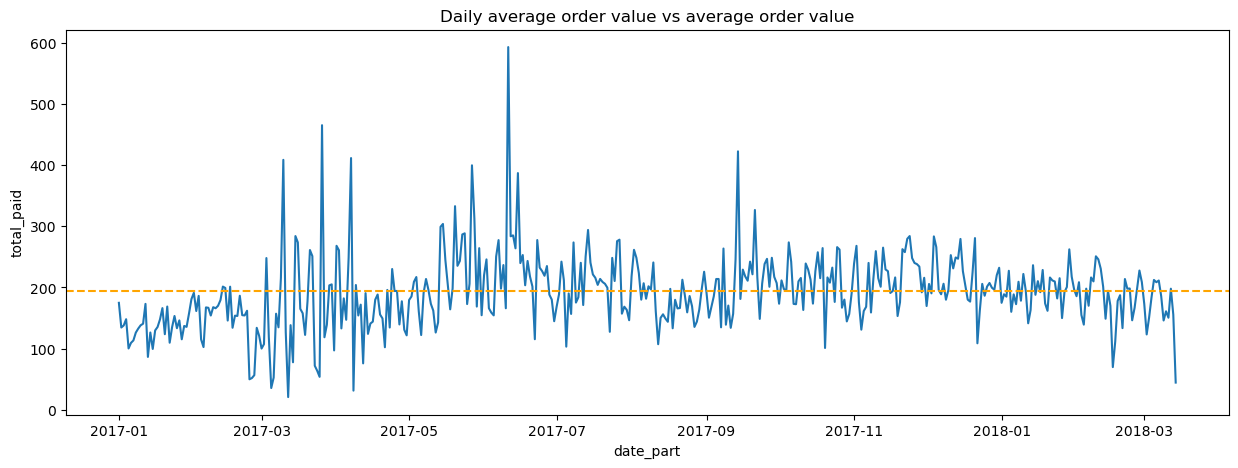

In [49]:
# use order_qu table

# extract date
orders_qu['date_part'] = orders_qu.created_date.dt.date

# completed orders
cmp_order_value = orders_qu[orders_qu['status']=='Completed']

# total_paid mean
average_order_value = cmp_order_value['total_paid'].mean()
display(average_order_value)

# display table
cmp_order_value.sort_values('date_part').head(100)

# daily total_paid mean
daily_order_value = cmp_order_value.groupby('date_part')[['total_paid']].mean()

cmp_order_value['total_paid'].sum()

import matplotlib.pyplot as plt

(
    plt.figure(figsize=(15, 5)),
    sns.lineplot(data=daily_order_value,
                 x='date_part',
                 y='total_paid'),
    plt.title('Daily average order value vs average order value')
#);
,plt.axhline(y=average_order_value, color='orange', linestyle='--'));

### 2. Discounted vs non discounted Orders : completed

In [50]:
# Calculate the number of products discounted vs. non-discounted
discounted_count = df_cmp[df_cmp["promotion"]]["sku"].nunique()
non_discounted_count = df_cmp[~df_cmp["promotion"]]["sku"].nunique()

print("Number of discounted products:", discounted_count)
print("Number of non-discounted products:", non_discounted_count)

Number of discounted products: 4906
Number of non-discounted products: 760


In [51]:
# Calculate revenue from products discounted vs. non-discounted
discounted_revenue = df_cmp.drop_duplicates(subset='order_id')[df_cmp["promotion"]]["total_paid"].sum()
non_discounted_revenue = df_cmp.drop_duplicates(subset='order_id')[~df_cmp["promotion"]]["total_paid"].sum()

print("Revenue from discounted products:", discounted_revenue)
print("Revenue from non-discounted products:", non_discounted_revenue)

Revenue from discounted products: 7396756.32
Revenue from non-discounted products: 581919.28


/var/folders/_s/vfqjvx2n6gl0d9lhmtd6m8l00000gn/T/ipykernel_86441/540648769.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  discounted_revenue = df_cmp.drop_duplicates(subset='order_id')[df_cmp["promotion"]]["total_paid"].sum()
/var/folders/_s/vfqjvx2n6gl0d9lhmtd6m8l00000gn/T/ipykernel_86441/540648769.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_discounted_revenue = df_cmp.drop_duplicates(subset='order_id')[~df_cmp["promotion"]]["total_paid"].sum()


In [52]:
# extract date part of created_date and create o_date column
df_cmp['o_date']=df_cmp['created_date'].dt.date

# promo vs non-promo number of orders and average order value, total revenue
# use df_cmp drop duplicate order_id for calc. of total_paid
promo_orders = (
    df_cmp
    .drop_duplicates(subset='order_id')[['order_id','total_paid','promotion','o_date']]
)
promo_orders.groupby('promotion').agg({'order_id':'count','total_paid':['mean','sum']})

order_id total_paid           
             count       mean        sum
promotion                               
False         2860    203.468  5.819e+05
True         38125    194.013  7.397e+06

<Axes: >

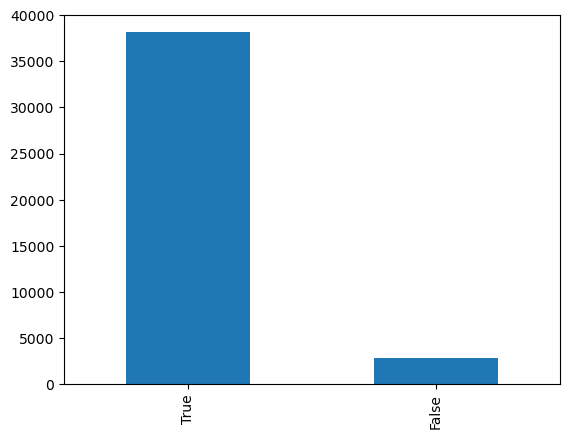

In [53]:
promo_orders.promotion.value_counts().plot(kind='bar')

### 3. Monthly Orders

In [54]:
#orders per month
monthly_orders = df_cmp.groupby(['promotion','year_month'])['order_id'].nunique().reset_index()

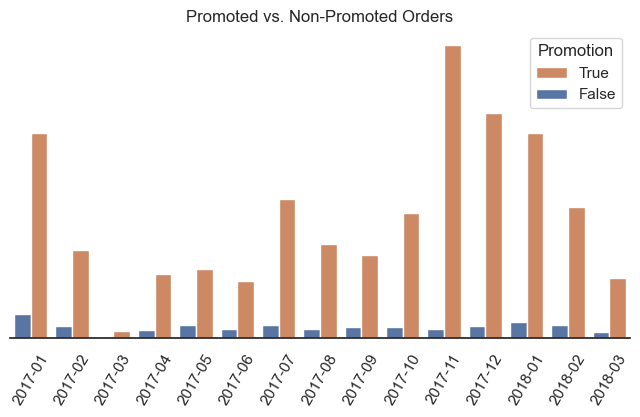

In [55]:
plt.figure(figsize=(8, 4))
sns.set(style="white")
sns.barplot(data=monthly_orders, x="year_month", y="order_id", hue="promotion")
plt.title("Promoted vs. Non-Promoted Orders")
#plt.legend(title="Promotion", loc="upper right")

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Reorder the labels and handles
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title="Promotion", loc="upper right")


plt.xlabel("")  # Empty x label
plt.ylabel("")  # Empty y label
plt.xticks(rotation=60)
plt.yticks([])
sns.despine(left=True)
plt.show()

### 4. Monthly Revenue

In [56]:
monthly_revenue = (
    df_cmp
    .drop_duplicates(subset='order_id')
    .groupby(['promotion','year_month'])['total_paid']
    .sum()
    .div(1000000)
    .reset_index())

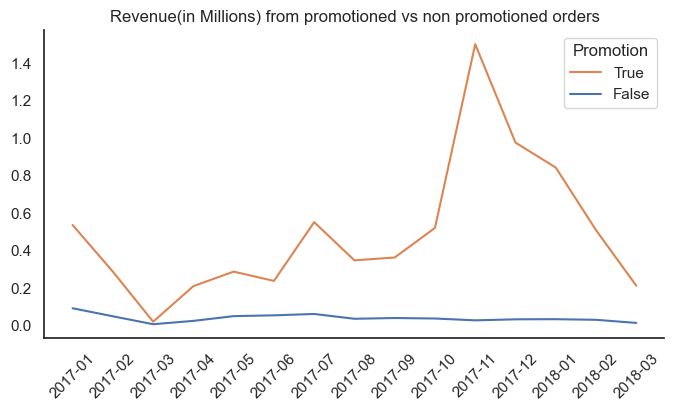

In [57]:
plt.figure(figsize=(8, 4))
sns.set(style="white")
sns.lineplot(data=monthly_revenue, x="year_month", y="total_paid", hue="promotion")
plt.title("Revenue(in Millions) from promotioned vs non promotioned orders")
#plt.legend(title="Promotion", loc="upper right")

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Reorder the labels and handles
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title="Promotion", loc="upper right")


plt.xlabel("")  # Empty x label
plt.ylabel("")  # Empty y label
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
#plt.yticks([])
sns.despine()
plt.show()

### 5. Revenue Trend (Daily)

Let's investigate when customers like to spend more money. Displaying the sum of daily order value on a line plot.

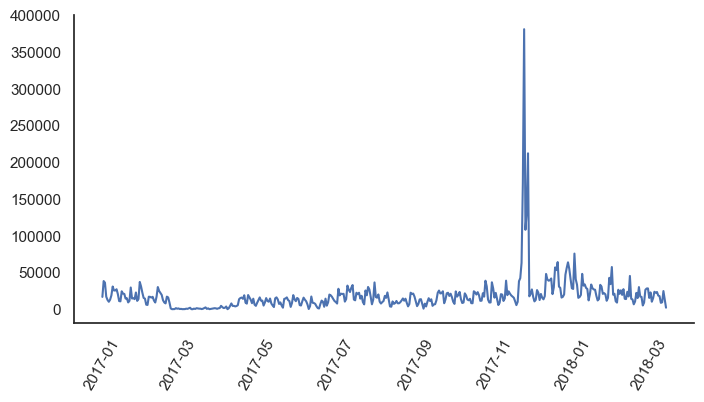

In [58]:
daily_revenue = (
    df_cmp.drop_duplicates(subset='order_id')
    .groupby(['o_date'])['total_paid']
    .sum()
 #   .div(1000000)
    .reset_index())


plt.figure(figsize=(8, 4))
sns.set(style="white")
sns.lineplot(data=daily_revenue,x='o_date',y='total_paid')


plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("")  # Empty x label
plt.ylabel("")  # Empty y label
plt.xticks(rotation=60)
sns.despine()
plt.show()

### 6. Monthly Discount Trend

In [59]:
monthly_discount = (
    df_cmp
    .groupby(['year_month'])['discount_perc']
    .mean()
    .reset_index())

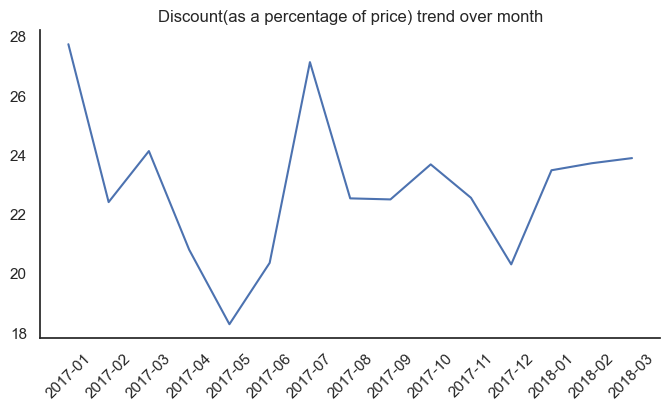

In [60]:
plt.figure(figsize=(8, 4))
sns.set(style="white")
sns.lineplot(data=monthly_discount, x="year_month", y="discount_perc")
plt.title("Discount(as a percentage of price) trend over month")
plt.xlabel("")  # Empty x label
plt.ylabel("")  # Empty y label
plt.xticks(rotation=45)
#plt.set_yticklables(['18%','20%','22%','24%','26%','28%'])
sns.despine()
plt.show()

### 7. Daily discount trend

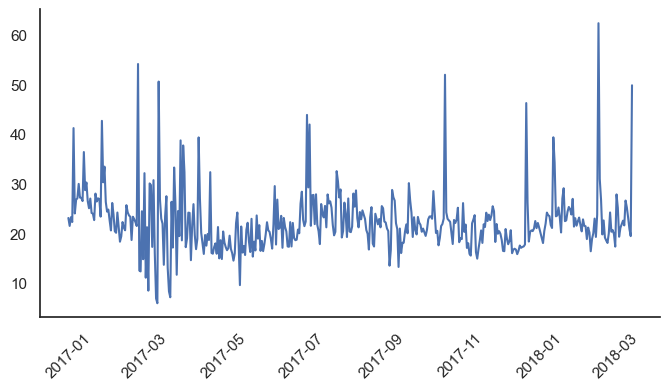

In [61]:
daily_discount = (
    df_cmp
    .groupby(['o_date'])['discount_perc']
    .mean()
    .reset_index()
)


plt.figure(figsize=(8, 4))
sns.set(style="white")
sns.lineplot(data=daily_discount,x='o_date',y='discount_perc')
plt.xlabel("")  # Empty x label
plt.ylabel("")  # Empty y label
plt.xticks(rotation=45)
sns.despine()
plt.show()

### 8. Weekly average discounts

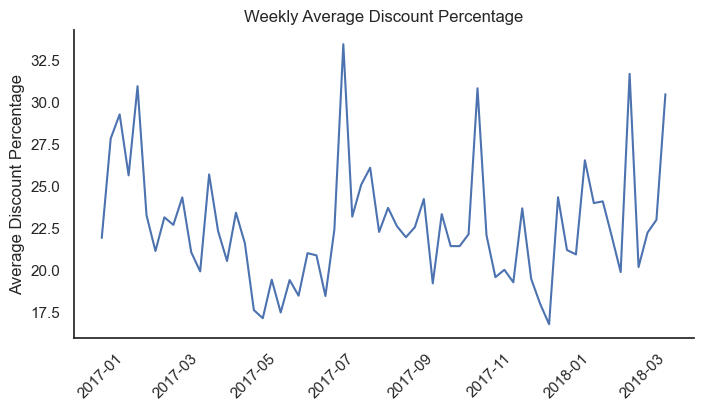

In [62]:
# Resample to calculate weekly average of discount percentage
weekly_avg_discount = (
    df_cmp[['discount_perc','created_date']]
    .resample('W-Mon',on='created_date')  # Resample by week starting on Monday
    .mean()  # Calculate weekly average
    .reset_index()
)

# Plot the weekly average discount percentage
plt.figure(figsize=(8, 4))
sns.set(style="white")
sns.lineplot(data=weekly_avg_discount, x='created_date', y='discount_perc')
plt.xlabel("")  # Empty x label
plt.ylabel("Average Discount Percentage")
plt.xticks(rotation=45)
sns.despine()
plt.title("Weekly Average Discount Percentage")
plt.show()

### 9. Weekly revenue

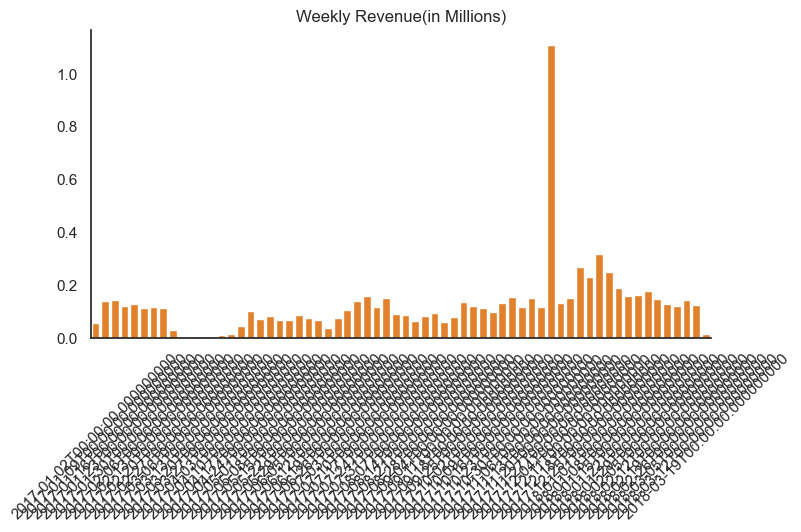

In [63]:
weekly_revenue = (
    df_cmp.drop_duplicates(subset='order_id')[['total_paid','created_date']]
    .resample('W-Mon',on='created_date')
    .sum()
    .div(1000000)
    .reset_index())


plt.figure(figsize=(8, 4))
sns.set(style="white")
sns.barplot(data=weekly_revenue, x="created_date", y="total_paid", color="tab:orange")
plt.title("Weekly Revenue(in Millions)")
plt.xlabel("")  # Empty x label
plt.ylabel("")  # Empty y label
plt.xticks(rotation=45)
sns.despine()
plt.show()

### 10. Discount & Revenue Monthly trend

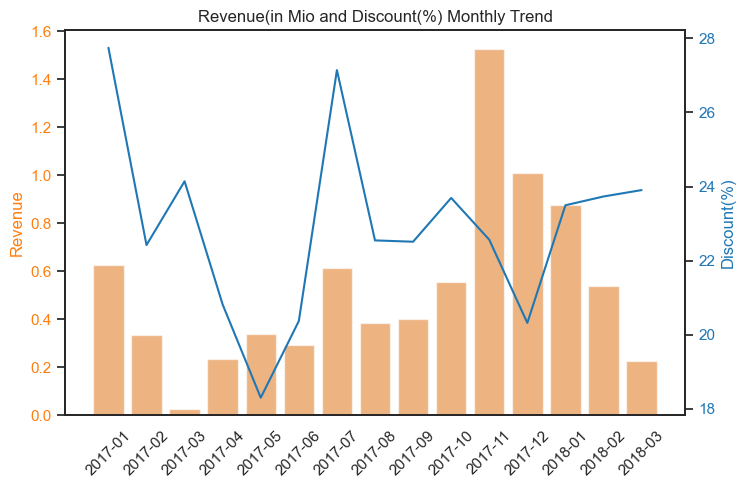

In [64]:
monthly_revenue2 = (
    df_cmp
    .drop_duplicates(subset='order_id')
    .groupby(['year_month'])['total_paid']
    .sum()
    .div(1000000)
    .reset_index())


# Set Seaborn style
sns.set(style="white")

# Create the first line plot for revenue
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1 = sns.barplot(data=monthly_revenue2, x="year_month", y="total_paid", color="tab:orange", alpha=0.6)
ax1.set_xlabel("")  # Empty x label
ax1.set_ylabel("Revenue", color="tab:orange")
ax1.tick_params(axis="y", labelcolor="tab:orange")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Create the second y-axis for the second line plot
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=monthly_discount, x="year_month", y="discount_perc", color="tab:blue")
ax2.set_ylabel("Discount(%)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Set title
plt.title("Revenue(in Mio and Discount(%) Monthly Trend")

# Display the combined plot
plt.show()

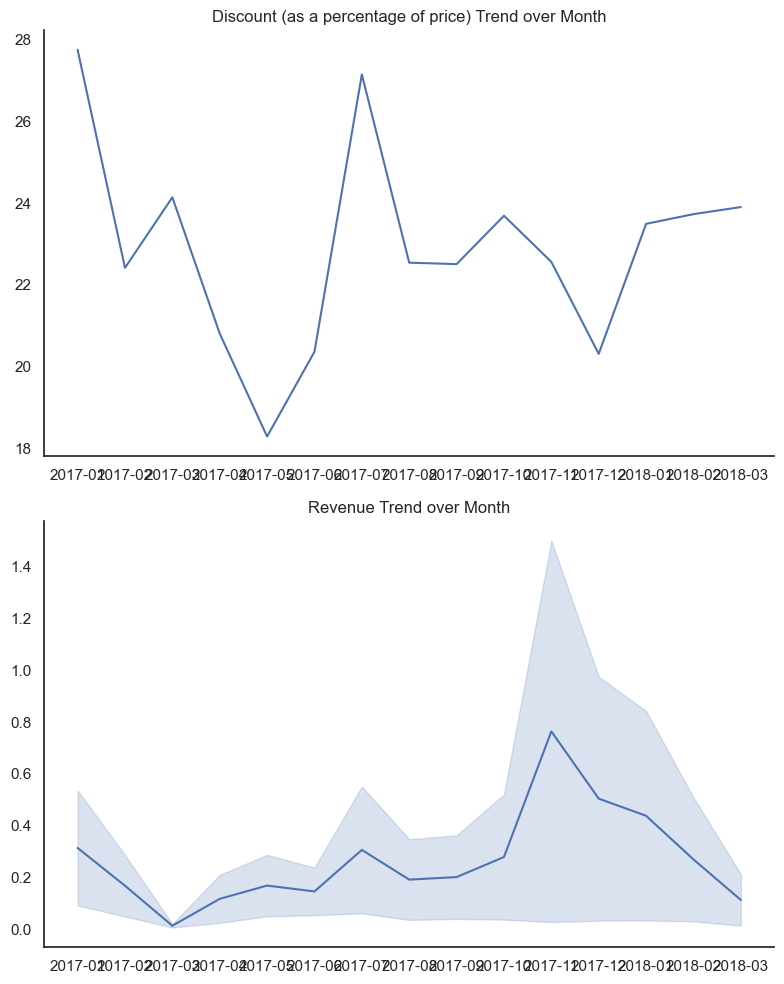

In [65]:
# Create subplots with two rows and one column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot 1: Discount Trend over Month
sns.set(style="white")
sns.lineplot(data=monthly_discount, x="year_month", y="discount_perc", ax=axes[0])
axes[0].set_title("Discount (as a percentage of price) Trend over Month")
axes[0].set_xlabel("")  # Empty x label
axes[0].set_ylabel("")  # Empty y label
#axes[0].set_xticks(rotation=45)
#axes[0].set_xticklabels(['18%', '20%', '22%', '24%', '26%', '28%'])
sns.despine()

# Plot 2: Total Paid Trend over Date with Promotion
sns.set(style="white")
sns.lineplot(data=monthly_revenue, x='year_month', y='total_paid', ax=axes[1])
axes[1].set_title("Revenue Trend over Month")
axes[1].set_xlabel("")  # Empty x label
axes[1].set_ylabel("")  # Empty y label
#axes[1].set_xticks(rotation=45)
sns.despine()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

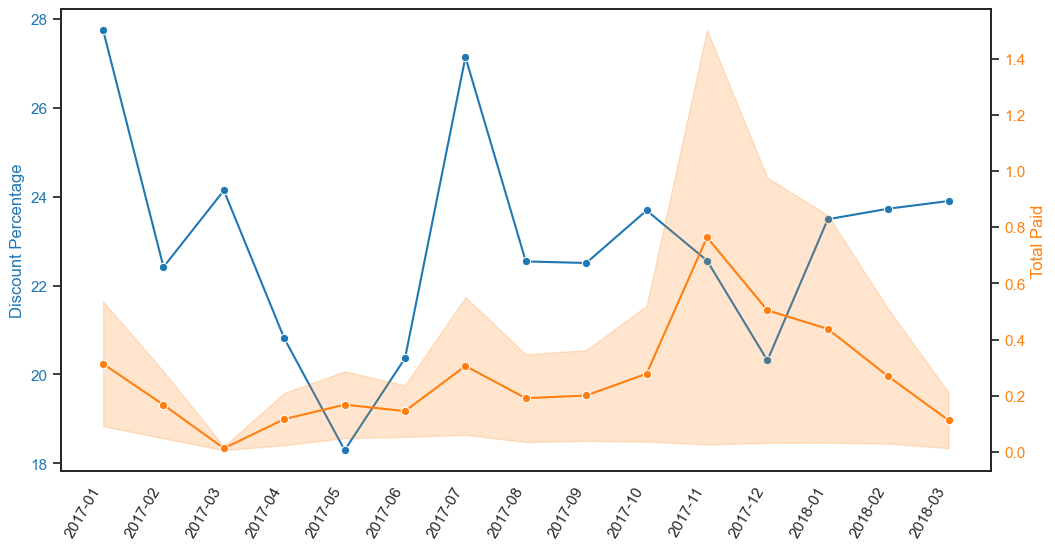

In [66]:
# Set Seaborn style
sns.set(style="white")

# Create the first line plot for discount trend
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1 = sns.lineplot(data=monthly_discount, x="year_month", y="discount_perc",marker='o', color="tab:blue")
ax1.set_xlabel("")  # Empty x label
ax1.set_ylabel("Discount Percentage", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Set x-axis ticks and rotate labels
x_ticks_positions = range(len(monthly_discount["year_month"]))
x_ticks_labels = monthly_discount["year_month"].tolist()
ax1.set_xticks(x_ticks_positions)
ax1.set_xticklabels(x_ticks_labels, rotation=60, ha='right')

# Create the second y-axis for the second line plot
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=monthly_revenue, x="year_month", y="total_paid", marker='o',color="tab:orange")
ax2.set_ylabel("Total Paid", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Set title
#plt.title("Discount and Total Paid Trends over Time")

# Display the combined plot
plt.show()

### 11. Relationship between discount percentage and total_paid

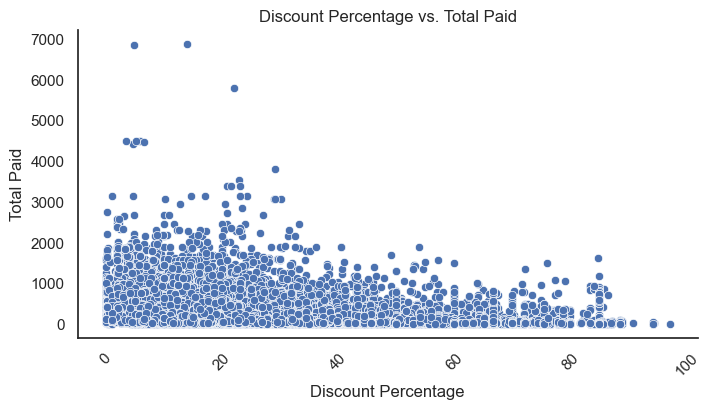

In [67]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_cmp, x="discount_perc", y="total_paid")
plt.title("Discount Percentage vs. Total Paid")
plt.xlabel("Discount Percentage")
plt.ylabel("Total Paid")
plt.xticks(rotation=45)
sns.despine()
plt.show()

### 12. Impact of Promotions on Order Value

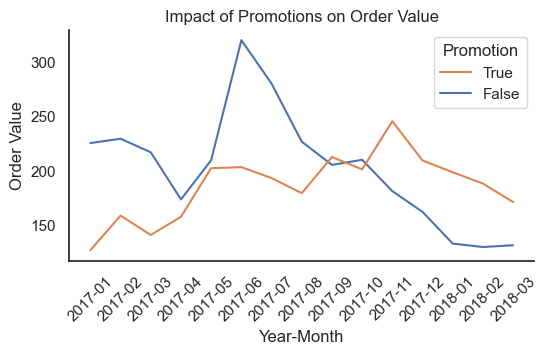

In [68]:
daily_avg_order_value = (
    df_cmp
    .drop_duplicates(subset='order_id')
    .groupby(['promotion','year_month'])['total_paid']
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 3))
sns.lineplot(data=daily_avg_order_value, x="year_month", y="total_paid", hue="promotion")

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Reorder the labels and handles
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title="Promotion", loc="upper right")


plt.xlabel("Year-Month")
plt.ylabel("Order Value")
plt.title("Impact of Promotions on Order Value")
plt.xticks(rotation=45)
sns.despine()
plt.show()

### 13. Discounts for different category

In [69]:
disc_cat = df_cmp.groupby(['category']).discount_perc.mean()
disc_cat

category
Accessories        25.407
Case               31.165
Desktop            22.425
Laptop             30.373
Miscellaneous      21.260
Music Devices      29.820
Phone              16.962
Storage Systems    18.071
Tablet             18.456
Watch              19.886
Name: discount_perc, dtype: float64

In [70]:
products_qu.price.describe()

count    6375.000
mean      220.397
std       335.020
min         2.990
25%        36.440
50%        79.000
75%       249.970
max      7179.000
Name: price, dtype: float64

### 14. Comparison of Discounts for Expensive vs. Cheap Products

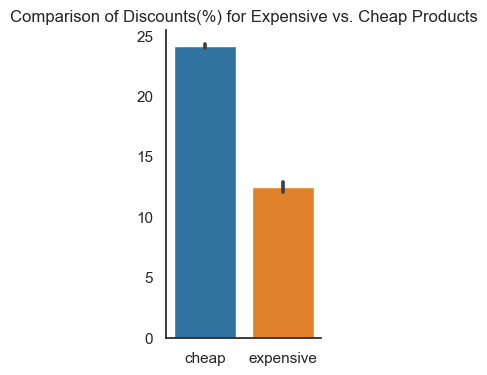

In [71]:
# Set Seaborn style
sns.set(style="white")

# Create the plot
plt.figure(figsize=(2, 4))
sns.barplot(data=df_cmp, x="price_range", y="discount_perc", palette=["tab:blue", "tab:orange"])
plt.title("Comparison of Discounts(%) for Expensive vs. Cheap Products")
plt.xlabel("")
plt.ylabel("")
sns.despine()
plt.show()

In [72]:
df_cmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53231 entries, 0 to 53230
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       53231 non-null  object        
 1   created_date   53231 non-null  datetime64[ns]
 2   total_paid     53231 non-null  float64       
 3   status         53231 non-null  object        
 4   sku            53231 non-null  object        
 5   name           53231 non-null  object        
 6   price          53231 non-null  float64       
 7   sell_price     53231 non-null  float64       
 8   qty            53231 non-null  int64         
 9   price_range    53231 non-null  object        
 10  category       53231 non-null  object        
 11  date           53231 non-null  datetime64[ns]
 12  promotion      53231 non-null  bool          
 13  discount       49404 non-null  float64       
 14  discount_perc  49404 non-null  float64       
 15  in_stock       5323

### 15. Most sold products

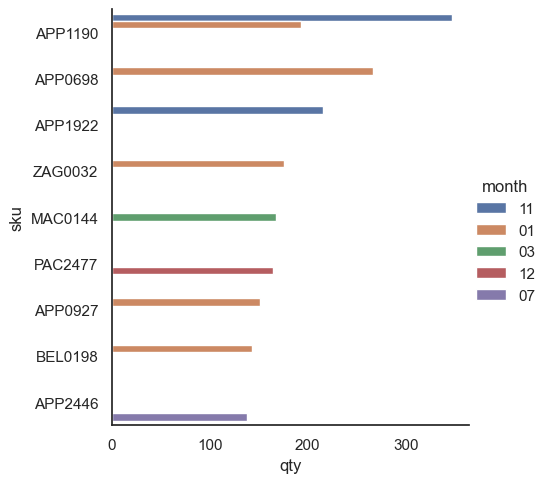

In [73]:
most_sold_products = (
    df_cmp
    .groupby(["month","sku"])["qty"]
    .sum()
    .nlargest(10)
    .reset_index())


#plt.figure(figsize=(10, 6))
#sns.barplot(data=most_sold_products, x="name", y="qty")

sns.catplot(kind='bar',
            data=most_sold_products,
            x='qty',
            y='sku',
            hue='month');

#sns.despine()
#plt.show()

In [74]:
most_sold_products

,month,sku,qty
0,11,APP1190,347
1,01,APP0698,266
2,11,APP1922,215
3,01,APP1190,193
4,01,ZAG0032,176
5,03,MAC0144,168
6,12,PAC2477,164
7,01,APP0927,151
8,01,BEL0198,143
9,07,APP2446,138


### 16. Comparison of Average Discount by Product Category

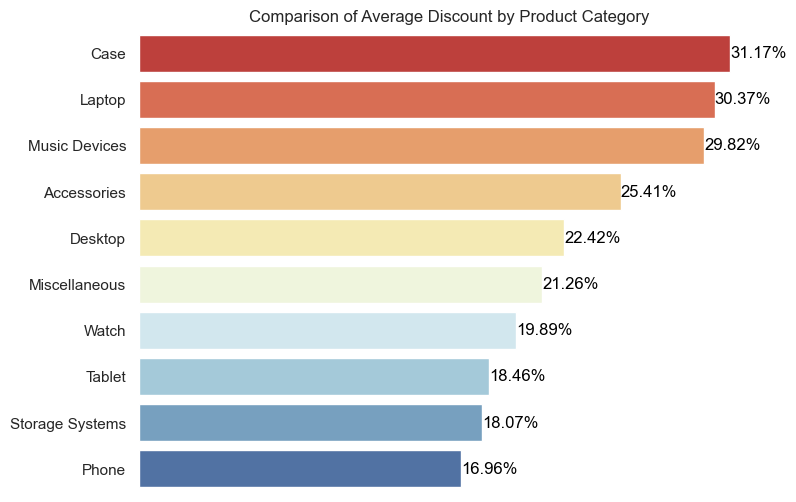

In [75]:
# Calculate revenue generation for each category
disc_by_category = df_cmp.groupby("category")['discount_perc'].mean().round(2).reset_index()
disc_by_category = disc_by_category.sort_values(by='discount_perc',ascending=False)

sns.set(style="white")

# Create a color palette with changing hues
#colors = sns.color_palette("husl", n_colors=len(df["category"].unique()))

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=disc_by_category, x="discount_perc", y="category", palette='RdYlBu')
plt.title("Comparison of Average Discount by Product Category")
plt.xlabel("")
plt.ylabel("")
sns.despine()
plt.xticks([])

for spine in ax.spines.values():
    spine.set_visible(False)

# Display percentage on each bar with two decimals
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', color='black')
plt.show()

### 17. Revenue Generation by Category

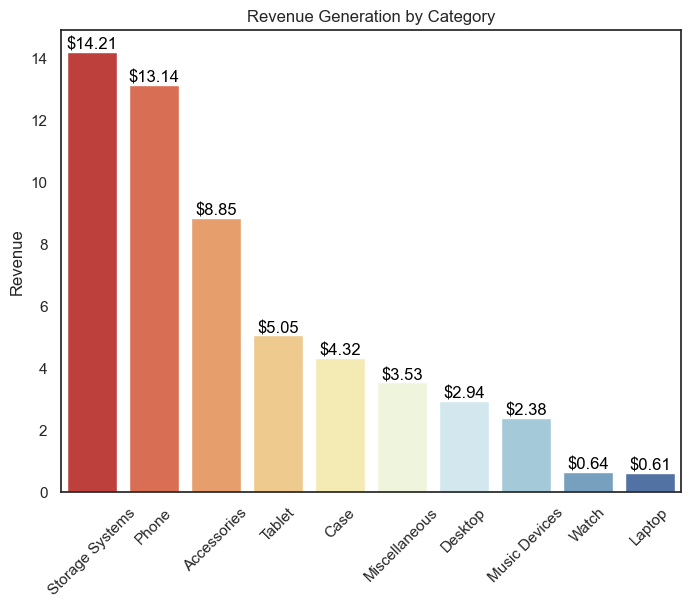

In [76]:
# Calculate revenue generation for each category
revenue_by_category = df.groupby("category")["total_paid"].sum().div(1000000).round(2).sort_values(ascending=False)

# Set Seaborn style
sns.set(style="white")

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=revenue_by_category.index, y=revenue_by_category.values, palette='RdYlBu')
plt.title("Revenue Generation by Category")
plt.xlabel("")
plt.ylabel("Revenue")
plt.xticks(rotation=45)

# Display revenue values on each bar
for p in ax.patches:
    ax.annotate(f'${p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', color='black')

plt.show()

### 18. Revenue Ditribution by Category

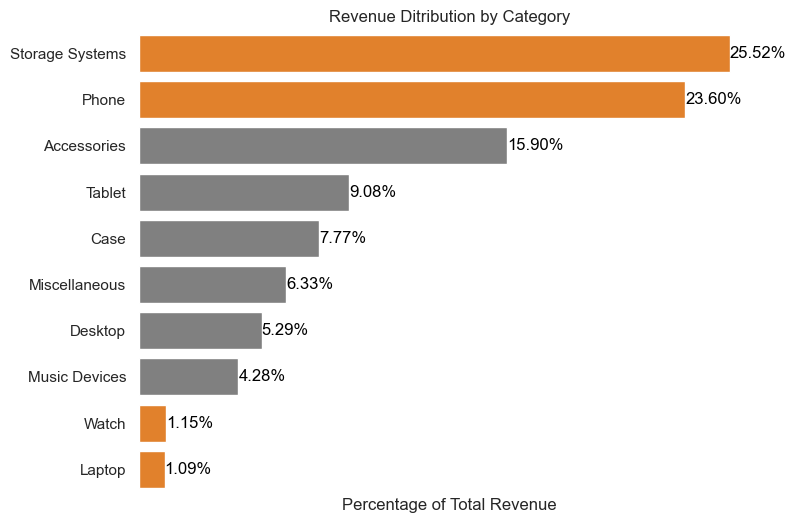

In [77]:
# Calculate total revenue for each category
category_revenue = df.groupby(["category"])["total_paid"].sum().reset_index()
total_revenue = category_revenue["total_paid"].sum()

# Calculate percentage of total revenue for each category
category_revenue["percentage_of_total"] = (category_revenue["total_paid"] / total_revenue) * 100
category_revenue = category_revenue.sort_values("percentage_of_total", ascending=False)

# Set custom color palette
top_bottom_palette = sns.color_palette(["#ff7f0e"] * 2 + ["gray"] * 6)

# #ff7f0e
sns.set(style="white")
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=category_revenue, x="percentage_of_total", y="category", palette=top_bottom_palette)
plt.title("Revenue Ditribution by Category")
plt.xlabel("Percentage of Total Revenue")
plt.ylabel("")
plt.xticks([])

for spine in ax.spines.values():
    spine.set_visible(False)

# Display percentage on each bar with two decimals on the right side
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', color='black')


plt.show()

### 19. Incomplete or Basket orders

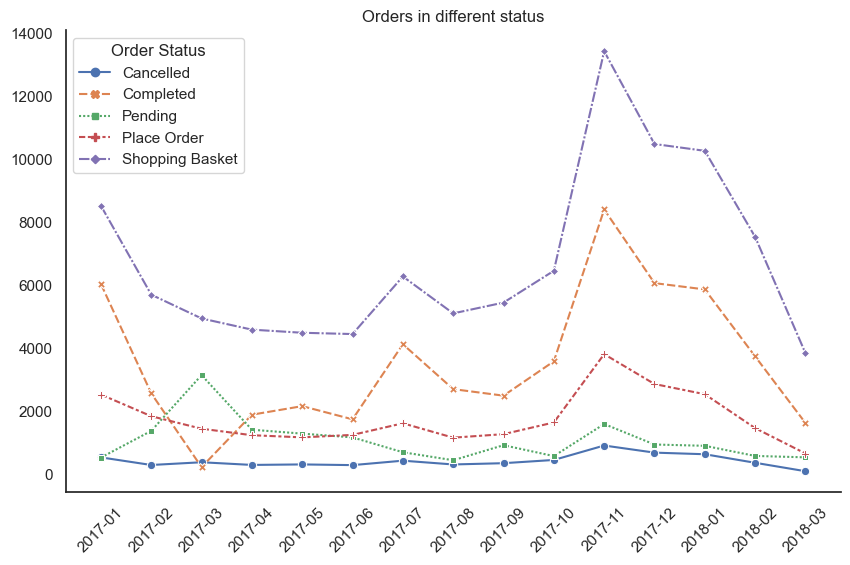

In [78]:
# Group by 'year_month' and 'status' and count the number of orders
order_counts = df.groupby(['year_month', 'status']).size().reset_index(name='count')

# Pivot the data for plotting
order_counts_pivot = order_counts.pivot(index='year_month', columns='status', values='count')

# Set Seaborn style
sns.set(style="white")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=order_counts_pivot, markers=True)
plt.title("Orders in different status")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45)
plt.legend(title="Order Status", loc="upper left")
sns.despine()
plt.show()

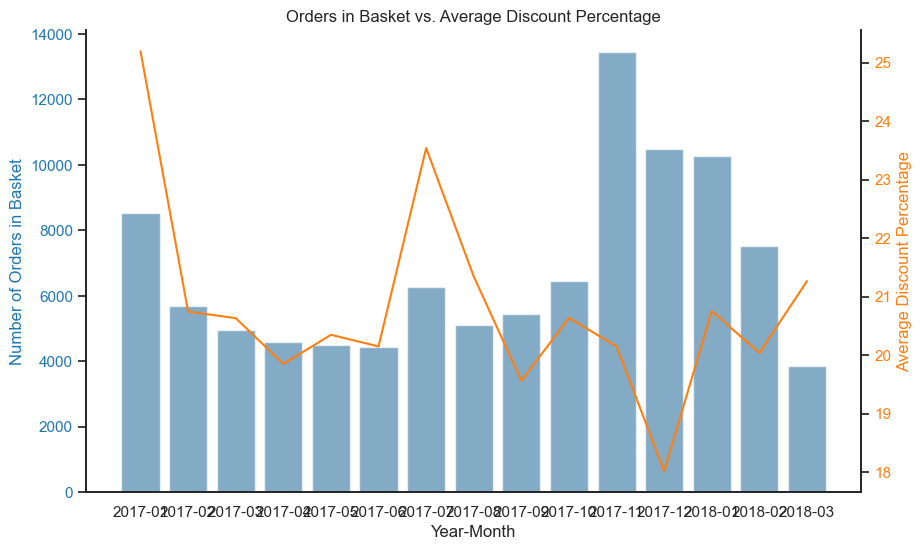

In [79]:
# Filter only 'In Basket' status
df_in_basket = df[df['status'] == 'Shopping Basket']

# Group by 'year_month' and calculate average discount percentage and count of orders
basket_avg_discount = df_in_basket.groupby('year_month')['discount_perc'].mean().reset_index()
basket_order_counts = df_in_basket.groupby('year_month').size().reset_index(name='order_count')

# Set Seaborn style
sns.set(style="white")

# Create the plot
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=basket_order_counts, x='year_month', y='order_count', color="tab:blue",alpha=0.6)
ax1.set_xlabel("Year-Month")
ax1.set_ylabel("Number of Orders in Basket", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=basket_avg_discount, x='year_month', y='discount_perc', color="tab:orange")
ax2.set_ylabel("Average Discount Percentage", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

plt.title("Orders in Basket vs. Average Discount Percentage")
plt.xticks(rotation=45)
sns.despine(right=False)
plt.show()